In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
import os

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
df = pd.read_csv('AAPL.csv', header=0, index_col=0)

In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-27,185.229996,187.279999,184.029999,184.160004,184.160004,25285300.0
2018-06-28,184.100006,186.210007,183.800003,185.500000,185.500000,17365200.0
2018-06-29,186.289993,187.190002,182.910004,185.110001,185.110001,22737700.0
2018-07-02,183.820007,187.300003,183.419998,187.179993,187.179993,17731300.0
2018-07-03,187.789993,187.949997,183.539993,183.919998,183.919998,13954800.0


In [5]:
forecast_col = 'Close'

In [6]:
df = df[[forecast_col]]

In [7]:
df.dropna(inplace = True)

In [8]:
scaler = MinMaxScaler()

data = scaler.fit_transform(df[forecast_col].values.reshape(df[forecast_col].shape[0], 1))
data

array([[0.00163566],
       [0.00149743],
       [0.00131314],
       ...,
       [0.95422731],
       [0.96490929],
       [0.94808642]])

In [9]:
# def processData(dataframe, fc_col_name=forecast_col, lk_bk=2, fc_out=1, dropNAN = True):
    
#     for i in range(1, lk_bk):
#         col_name = fc_col_name + '(' + str(-i) + ')'
#         dataframe[col_name] = dataframe[fc_col_name].shift(i)
        
#     dataframe['Prediction'] = dataframe[fc_col_name].shift(-fc_out)
    
#     if(dropNAN):
#         dataframe.dropna(inplace=True)
    
#     return dataframe

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

In [10]:
look_back = 14
# forecast_out = 1
X,y = processData(data,look_back)

In [11]:
train_pct = 0.80

X_train,X_test = X[:int(X.shape[0]*train_pct)],X[int(X.shape[0]*train_pct):]
y_train,y_test = y[:int(y.shape[0]*train_pct)],y[int(y.shape[0]*train_pct):]

#Reshape data into (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7564, 14, 1)
(1891, 14, 1)
(7564,)
(1891,)


In [12]:

adam = Adam(lr=0.003)

file_path = './model_checkpoints/daily_lstm_model_weights.h5'

callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)

callbacks = [early_stopping, callback_checkpoint, reduce_lr]

model = Sequential()

model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

model.add(LSTM(16))

model.add(Dense(1))

model.compile(loss='mse', optimizer=adam)

In [13]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks, shuffle=True)

Train on 7564 samples, validate on 1891 samples
Epoch 1/100
7564/7564 [==============================] - 4s 516us/step - loss: 8.3663e-05 - val_loss: 0.0023
Epoch 2/100
7564/7564 [==============================] - 3s 377us/step - loss: 7.5321e-06 - val_loss: 9.3021e-04
Epoch 3/100
7564/7564 [==============================] - 3s 380us/step - loss: 1.1412e-05 - val_loss: 0.0026
Epoch 4/100
7564/7564 [==============================] - 3s 423us/step - loss: 7.4683e-06 - val_loss: 7.4730e-04
Epoch 5/100
7564/7564 [==============================] - 3s 351us/step - loss: 6.5790e-06 - val_loss: 7.0469e-04
Epoch 6/100
7564/7564 [==============================] - 3s 350us/step - loss: 6.8134e-06 - val_loss: 0.0023
Epoch 7/100
7564/7564 [==============================] - 3s 347us/step - loss: 4.5820e-06 - val_loss: 5.8730e-04
Epoch 8/100
7564/7564 [==============================] - 3s 348us/step - loss: 5.1804e-06 - val_loss: 3.7206e-04
Epoch 9/100
7564/7564 [==============================] - 2s 

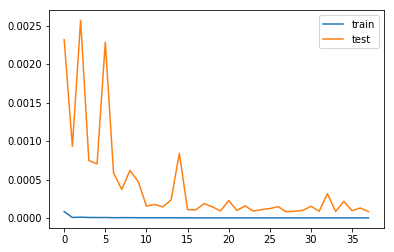

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
model.load_weights(file_path)
os.remove(file_path)

In [16]:
def evaluate_model(trained_model, train, test, actual):

    X_train_prediction = trained_model.predict(train)
    X_test_prediction = trained_model.predict(test)

    plt.figure(figsize=(20,10))

    plt.plot(scaler.inverse_transform(actual.reshape(-1,1)), label="Actual")
    plt.plot(scaler.inverse_transform(X_train_prediction), label="Train", alpha=0.8)
    plt.plot(np.linspace(7565,7565 + len(X_test_prediction), len(X_test_prediction)), scaler.inverse_transform(X_test_prediction), label="Test", color='orange', alpha=0.8)
    plt.legend(fontsize="xx-large")


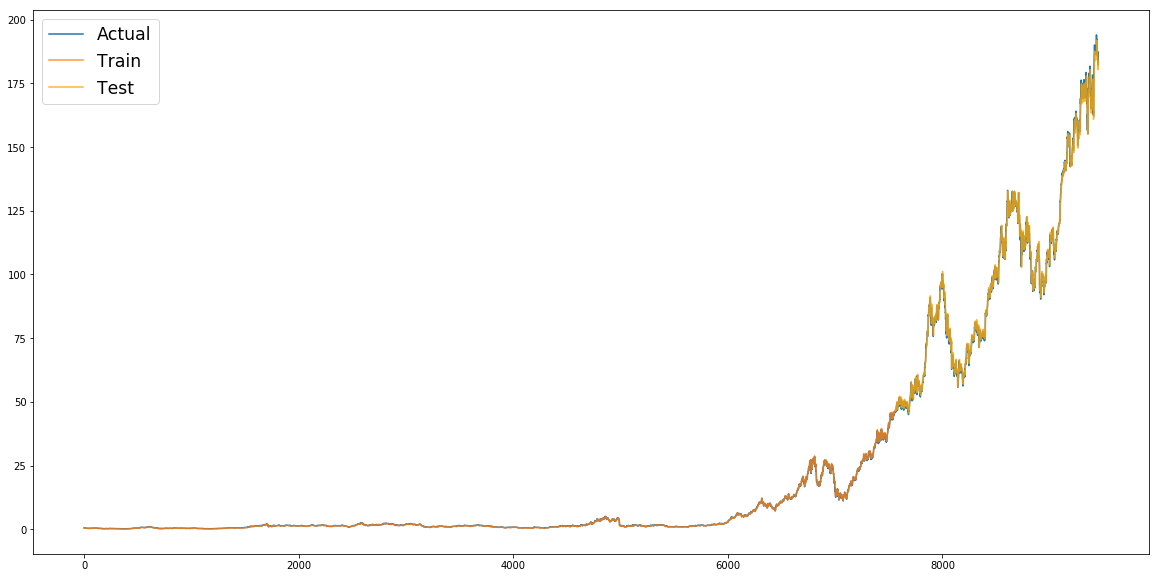

In [17]:
evaluate_model(model, X_train, X_test, y)

In [18]:
def predict(input_value):

    Xt = model.predict(input_value.reshape(1,look_back,1))
 
    return scaler.inverse_transform(Xt)[0][0]

In [19]:
i = X_test.shape[0] - 1

# Make sure input is scaled
prediction = predict(X_test[i])

actual_value = scaler.inverse_transform(y_test[i].reshape(-1,1))[0][0]

print('Predicted: {0:.4f}, Actual: {1:.4f}'.format(prediction, actual_value))

accuracy = (prediction / actual_value) * 100

print('Accuracy:{0:.2f}%'.format(accuracy))

Predicted: 183.4869, Actual: 187.1800
Accuracy:98.03%


In [20]:
def save_model(model, filepath):
    model.save(filepath) 

In [21]:
save_model(model, './model_checkpoints/daily_lstm_full_model.h5')